# 1991 ~ 2018 KBO 타자 데이터를 이용한 연봉 예측

### 바로가기

-----

### 필요한 라이브러리 import

In [5]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

mpl.rc('font', family='NanumGothic')  # matplotlib에서 한글 폰트로 NanumGothic을 사용

# 1. 데이터 불러오기

[원본 데이터(kaggle.com)](https://www.kaggle.com/bluemumin/kbo-baseball-for-kaggle)

In [6]:
batter = pd.read_csv('./data/1990_2018_KBO_Batter.csv')
batter.columns

Index(['Batter_Name', 'Age', 'G', 'PA', 'AB', 'R', 'H', '1B', '2B', '3B', 'HR',
       'TB', 'RBI', 'SB', 'CS', 'BB', 'HBP', 'FBP', 'IBB', 'SO', 'GDP', 'SAC',
       'SF', 'Year', 'Salary', 'WAR', 'Year_Born', 'Hand', 'CP', 'TP', 'AVG',
       'OBP', 'SLG', 'OPS', 'P_Year', 'YAB', 'YOPS'],
      dtype='object')

In [7]:
batter.head()

,Batter_Name,Age,G,PA,AB,R,H,1B,2B,3B,...,Hand,CP,TP,AVG,OBP,SLG,OPS,P_Year,YAB,YOPS
0,백용환,24,26,58,52,4,9,5,4,0,...,우타우투,포수,포수,0.173,0.259,0.250,0.509,2014,79,0.580
1,백용환,25,47,86,79,8,14,8,2,0,...,우타우투,포수,포수,0.177,0.226,0.354,0.580,2015,154,0.784
2,백용환,26,65,177,154,22,36,20,6,0,...,우타우투,포수,포수,0.234,0.316,0.468,0.784,2016,174,0.581
3,백용환,27,80,199,174,12,34,23,7,0,...,우타우투,포수,포수,0.195,0.276,0.305,0.581,2017,17,0.476
4,백용환,28,15,20,17,2,3,3,0,0,...,우타우투,포수,포수,0.176,0.300,0.176,0.476,2018,47,0.691


### 속성 정리

G 게임 수 | Age 나이 | PA 타석 | AB 타수 | R 득점 | H 안타 | 1B 1루타 | 2B 2루타 | 3B 3루타 | HR 홈런 | TB 총 루타 수 | RBI 타점 | SB 도루 성공 | 

CS 도루 실패 | FBP(BB + HBP) | BB 볼넷 수 | HBP 몸에 맞는 공 | IBB 고의 사구 | SO 삼진 | GDP 병살 | SAC 희생타 | SF 희생 플라이 | Year 해당 시즌 | 

Salary 해당 시즌의 연봉 | WAR 대체 선수 대비 승리 기여도 | Year_Born 선수 출생일 | Hand 타석 위치 | CP 최근 포지션 | TP 통합 포지션 | AVG 타율 | 

OBP 출루율 | SLG 장타율 | OPS(OBP + SLG) | P_Year 다음 시즌 | YAB 다음 시즌 타석 수 | YOPS 다음 시즌 OPS



In [8]:
print(batter.shape)

(1913, 37)


<b>연봉 정보</b>

In [9]:
batter['Salary'].describe()  # 단위: 만 원

count      1913.000000
mean      14112.135389
std       22446.615221
min        1700.000000
25%        2700.000000
50%        5300.000000
75%       15000.000000
max      250000.000000
Name: Salary, dtype: float64

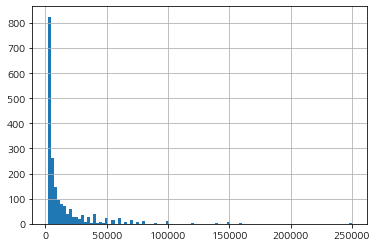

In [10]:
batter['Salary'].hist(bins=100)  # 연봉 분포 출력

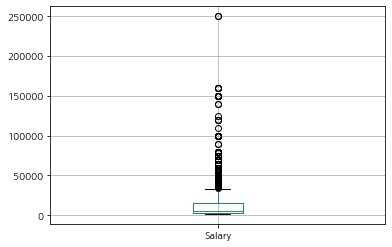

In [11]:
batter.boxplot(column=['Salary'])

<b>Box Plot?</b>

상자 그림(Box Plot)은 데이터의 사분위값 특성을 이용하여 데이터의 분포를 파악하는 그림 표현 방법.

데이터의 기준을 제시해주는 그림. 그림 상에서 급여가 25000(만 원)이 넘는 데이터는 일반적이지 않다고 볼 수 있음.

-----

### 회귀 분석에 사용할 특성

In [12]:
# 필요 없는 데이터 제거
batter_df = batter.drop(['Batter_Name', 'Year_Born', 'P_Year', 'YAB', 'YOPS'], axis=1)

In [13]:
def plot_hist_each_column(df):
    plt.rcParams['figure.figsize'] = [25, 30]
    fig = plt.figure(1)
    
    # df의 column 개수 만큼의 subplot을 출력
    for i in range(len(df.columns)):
        ax = fig.add_subplot(8, 4, i+1)
        plt.hist(df[df.columns[i]], bins=50)
        ax.set_title(df.columns[i])
    plt.show()

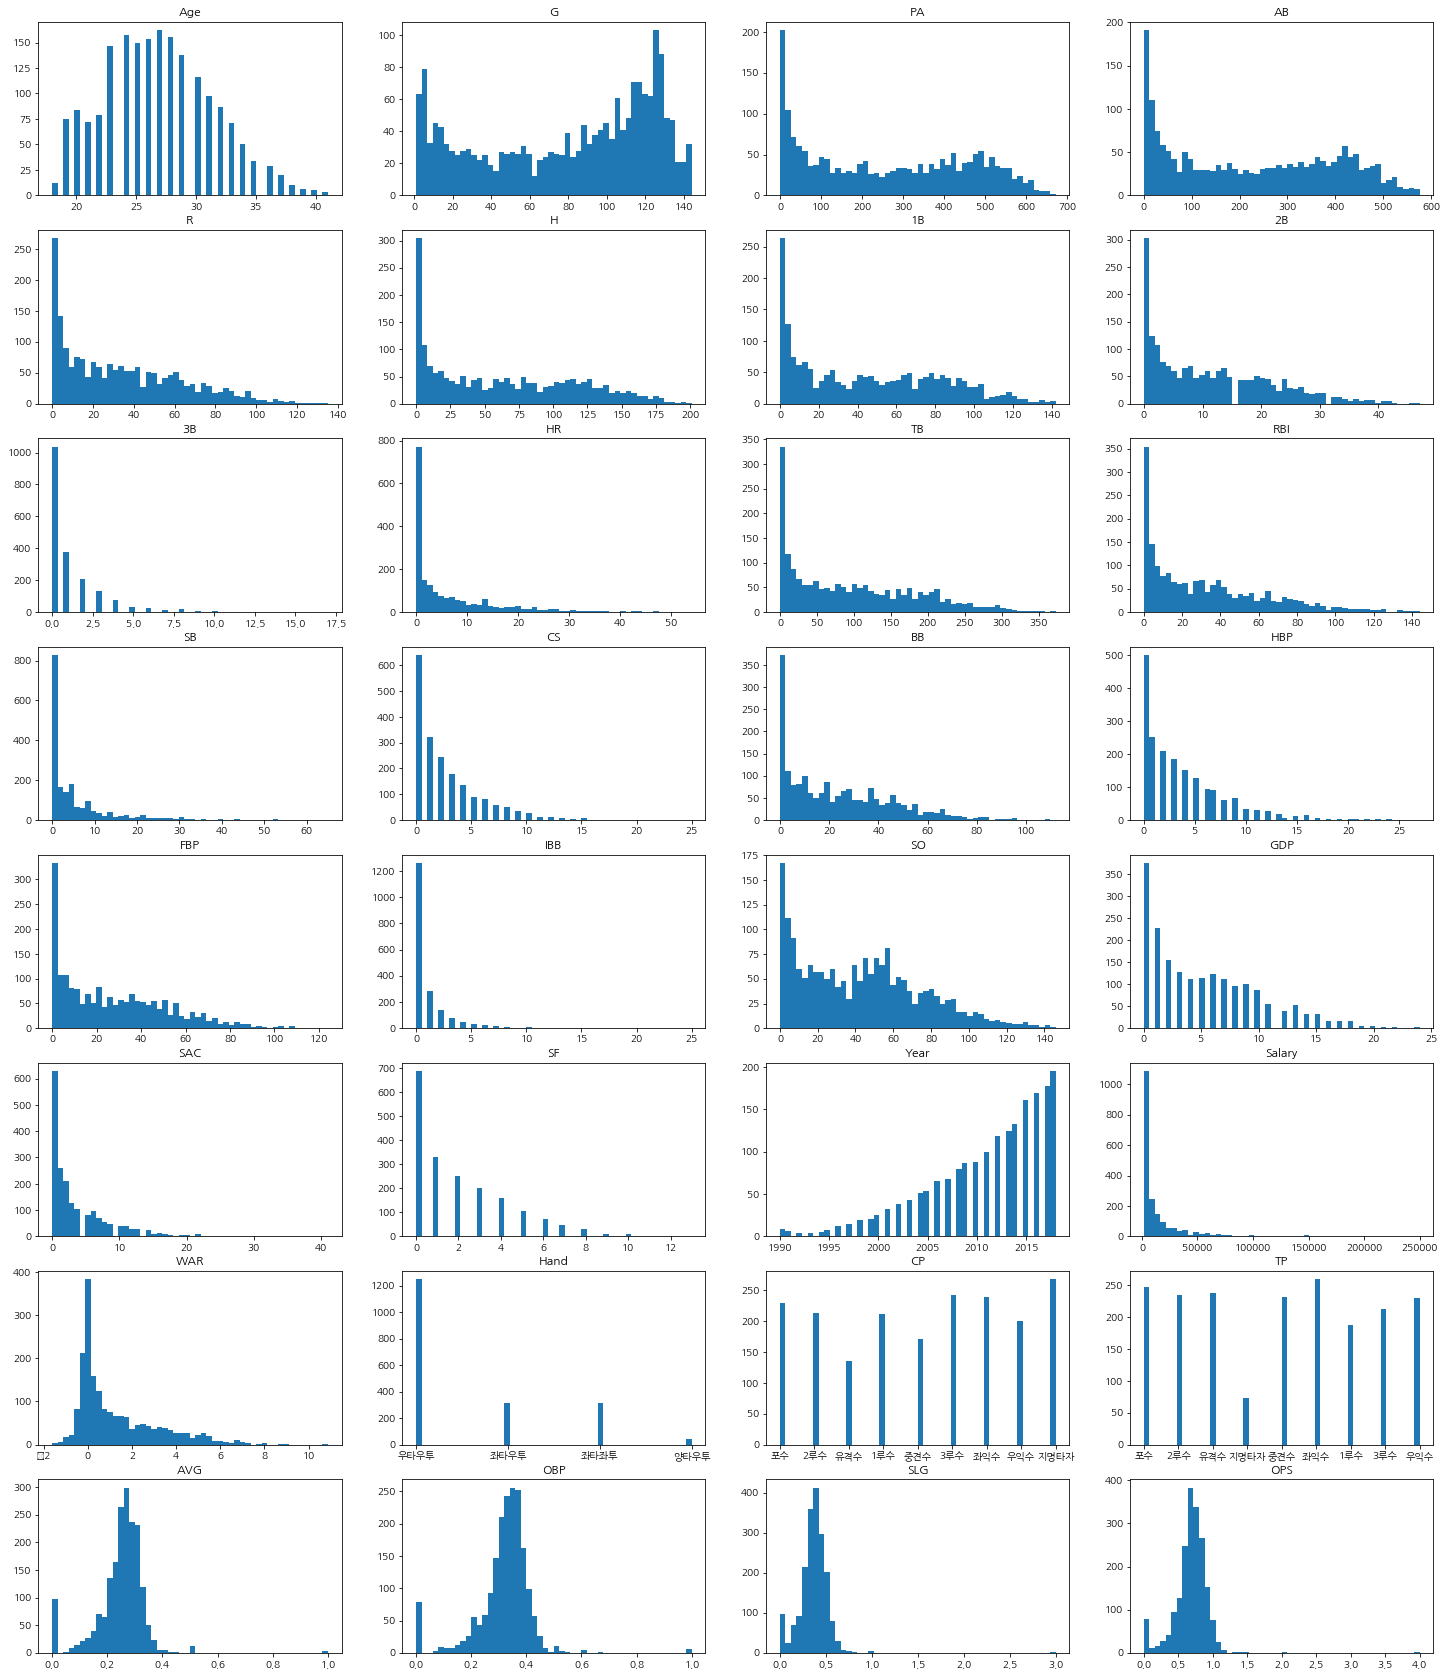

In [14]:
plot_hist_each_column(batter_df)

-----

# 2. 타자의 연봉 예측하기

### 손실 데이터 처리

In [15]:
# 데이터의 특성 상 빈 셀을 0으로 채우는 것이 가장 적합
batter_df = batter_df.fillna(0)

### 범주형 데이터 수치화

In [16]:
# 범주형 데이터(Hand, CP, TP)를 one-hot encoding으로 변환
batter_df = pd.get_dummies(batter_df)
batter_df.head(5)

,Age,G,PA,AB,R,H,1B,2B,3B,HR,...,CP_포수,TP_1루수,TP_2루수,TP_3루수,TP_우익수,TP_유격수,TP_좌익수,TP_중견수,TP_지명타자,TP_포수
0,24,26,58,52,4,9,5,4,0,0,...,1,0,0,0,0,0,0,0,0,1
1,25,47,86,79,8,14,8,2,0,4,...,1,0,0,0,0,0,0,0,0,1
2,26,65,177,154,22,36,20,6,0,10,...,1,0,0,0,0,0,0,0,0,1
3,27,80,199,174,12,34,23,7,0,4,...,1,0,0,0,0,0,0,0,0,1
4,28,15,20,17,2,3,3,0,0,0,...,1,0,0,0,0,0,0,0,0,1


### 학습 데이터와 테스트 데이터 분리

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

X = batter_df[batter_df.columns.difference(['Salary'])]
y = batter_df['Salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

### 특성 단위 맞춰주기: 스케일링

In [18]:
# pandas 형태로 정의된 데이터를 출력할 때, scientific-notation(ex. 1.00844665e+02)이 아닌 float 모양으로 출력되게 함
pd.options.mode.chained_assignment = None

In [19]:
# 특성 각각에 대한 scaling을 수행하는 함수 정의. (sklearn에서 못 찾아서...)
def standard_scaling(df, scale_columns):
    for col in scale_columns:
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = df[col].apply(lambda x: (x-series_mean) / series_std)
    return df

In [20]:
# 특성 각각에 대한 scaling을 수행
print(batter_df.columns)
scale_columns = ['Age', 'G', 'PA', 'AB', 'R', 'H', '1B', '2B', '3B', 'HR', 'TB', 'RBI',
       'SB', 'CS', 'BB', 'HBP', 'FBP', 'IBB', 'SO', 'GDP', 'SAC', 'SF', 'Year', 'WAR', 
       'AVG', 'OBP', 'SLG', 'OPS']  # 범주형 데이터 제외

# 훈련 데이터와 테스트 데이터에 각각 적용
X_train = standard_scaling(X_train, scale_columns)
X_test = standard_scaling(X_test, scale_columns)

Index(['Age', 'G', 'PA', 'AB', 'R', 'H', '1B', '2B', '3B', 'HR', 'TB', 'RBI',
       'SB', 'CS', 'BB', 'HBP', 'FBP', 'IBB', 'SO', 'GDP', 'SAC', 'SF', 'Year',
       'Salary', 'WAR', 'AVG', 'OBP', 'SLG', 'OPS', 'Hand_양타우투', 'Hand_우타우투',
       'Hand_좌타우투', 'Hand_좌타좌투', 'CP_1루수', 'CP_2루수', 'CP_3루수', 'CP_우익수',
       'CP_유격수', 'CP_좌익수', 'CP_중견수', 'CP_지명타자', 'CP_포수', 'TP_1루수', 'TP_2루수',
       'TP_3루수', 'TP_우익수', 'TP_유격수', 'TP_좌익수', 'TP_중견수', 'TP_지명타자', 'TP_포수'],
      dtype='object')


-----

### 회귀 분석 적용하기

<b>회귀 분석 계수 학습 & 학습된 계수 출력</b>

In [21]:
from sklearn import linear_model

# 회귀 모델 학습
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

In [22]:
# 학습된 계수 출력
print(lr.coef_)

[ 7.50589734e+03  1.63118215e+03 -4.23130412e+02  6.87814927e+05
  8.13284511e+02  6.86195519e+03  5.19091754e+04 -2.76711160e+03
 -7.45433791e+02  8.31277083e+01 -2.66945493e+03 -2.22029354e+03
 -3.89529642e+03  4.11310685e+03  2.73320262e+03  5.36815310e+03
 -8.26316128e+02  4.82425474e+04 -3.22869922e+03  1.90369158e+03
  6.32568686e+03  1.14838637e+04  4.84148691e+03 -3.44503120e+03
  9.56614219e+02  1.63709938e+03  8.51317598e+02  3.39951091e+03
  1.00243081e+03 -5.68780515e+03 -8.05534243e+05 -3.14836017e+03
 -4.36745645e+02  1.79388258e+04  1.96302864e+03  9.87909533e+03
  3.54875582e+03 -1.62124132e+03  5.59525149e+03  3.08017611e+03
  1.20061352e+03  2.34353552e+03 -4.14807436e+02  5.68907201e+03
 -1.04313531e+03  1.19835248e+03 -9.21018521e+03 -2.84362168e+03
 -5.74170742e+03  2.07874524e+03]


-----

# 3. 예측 모델 평가하기

### 가장 영향력이 강한 특성

In [23]:
import statsmodels.api as sm

# statsmodel 라이브러리로 회귀 분석을 수행
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     38.59
Date:                Wed, 03 Jun 2020   Prob (F-statistic):          1.46e-211
Time:                        12:49:37   Log-Likelihood:                -16859.
No. Observations:                1530   AIC:                         3.381e+04
Df Residuals:                    1485   BIC:                         3.405e+04
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8393.1018    580.014     14.471      0.000    7255.369    9530.835
1B          7505.8973   1719.211      4.366      0.000    4133.557    1.09e+04
2B          1631.1821   1166.062      1.399      0.162    -656.123    3918.487
3B          -423.1304    594.715     -0.711      0.477   -1589.701     743.440
AB          6.878e+05   4.51e+05      1.524      0.128   -1.98e+05    1.57e+06
AVG          813.2845   1353.343      0.601      0.548   -1841.382    3467.951
Age         6861.9552    488.474     14.048      0.000    5903.782    7820.128
BB          5.191e+04   3.13e+04      1.656      0.098   -9573.412    1.13e+05
CP_1루수     -1834.5447   1393.009     -1.317      0.188   -4567.020     897.930
CP_2루수       187.1331   1782.124      0.105      0.916   -3308.614    3682.880
CP_3루수      1015.6946   1623.761      0.626      0.532   -2169.414    4200.803
CP_우익수     -1736.8881   1670.119     -1.040      0.299   -5012.932    1539.155
CP_유격수     -1287.7267   2180.416     -0.591      0.555   -5564.749    2989.296
CP_좌익수     -2962.7295   1562.751     -1.896      0.058   -6028.165     102.705
CP_중견수      5045.6737   1684.569      2.995      0.003    1741.287    8350.061
CP_지명타자     3665.7695   1437.260      2.551      0.011     846.495    6485.044
CP_포수       6300.7200   3837.019      1.642      0.101   -1225.833    1.38e+04
CS          -826.3161    684.821     -1.207      0.228   -2169.636     517.003
FBP         4.824e+04    2.9e+04      1.666      0.096   -8558.993    1.05e+05
G          -3228.6992   1290.469     -2.502      0.012   -5760.035    -697.364
GDP         1903.6916    760.174      2.504      0.012     412.563    3394.820
H           6325.6869   1316.510      4.805      0.000    3743.270    8908.104
HBP         1.148e+04   5941.332      1.933      0.053    -170.431    2.31e+04
HR          4841.4869   1336.079      3.624      0.000    2220.684    7462.290
Hand_양타우투  -1346.7557   2239.419     -0.601      0.548   -5739.516    3046.005
Hand_우타우투   3054.8897    850.920      3.590      0.000    1385.756    4724.023
Hand_좌타우투   3735.3748   1052.832      3.548      0.000    1670.179    5800.571
Hand_좌타좌투   2949.5931   1100.640      2.680      0.007     790.618    5108.568
IBB         3399.5109    575.808      5.904      0.000    2270.028    4528.994
OBP         1002.4308   1600.261      0.626      0.531   -2136.582    4141.443
OPS        -5687.8052   4617.589     -1.232      0.218   -1.47e+04    3369.885
PA         -8.055e+05   5.18e+05     -1.555      0.120   -1.82e+06     2.1e+05
R          -3148.3602   1966.337     -1.601      0.110   -7005.453     708.732
RBI         -436.7456   2066.836     -0.211      0.833   -4490.975    3617.484
SAC         1.794e+04   1.27e+04      1.418      0.156   -6880.309    4.28e+04
SB          1963.0286    763.880      2.570      0.010     464.630    3461.427
SF

[Text(0, 0, 'const'),
 Text(0, 0, '1B'),
 Text(0, 0, '2B'),
 Text(0, 0, '3B'),
 Text(0, 0, 'AB'),
 Text(0, 0, 'AVG'),
 Text(0, 0, 'Age'),
 Text(0, 0, 'BB'),
 Text(0, 0, 'CP_1루수'),
 Text(0, 0, 'CP_2루수'),
 Text(0, 0, 'CP_3루수'),
 Text(0, 0, 'CP_우익수'),
 Text(0, 0, 'CP_유격수'),
 Text(0, 0, 'CP_좌익수'),
 Text(0, 0, 'CP_중견수'),
 Text(0, 0, 'CP_지명타자'),
 Text(0, 0, 'CP_포수'),
 Text(0, 0, 'CS'),
 Text(0, 0, 'FBP'),
 Text(0, 0, 'G'),
 Text(0, 0, 'GDP'),
 Text(0, 0, 'H'),
 Text(0, 0, 'HBP'),
 Text(0, 0, 'HR'),
 Text(0, 0, 'Hand_양타우투'),
 Text(0, 0, 'Hand_우타우투'),
 Text(0, 0, 'Hand_좌타우투'),
 Text(0, 0, 'Hand_좌타좌투'),
 Text(0, 0, 'IBB'),
 Text(0, 0, 'OBP'),
 Text(0, 0, 'OPS'),
 Text(0, 0, 'PA'),
 Text(0, 0, 'R'),
 Text(0, 0, 'RBI'),
 Text(0, 0, 'SAC'),
 Text(0, 0, 'SB'),
 Text(0, 0, 'SF'),
 Text(0, 0, 'SLG'),
 Text(0, 0, 'SO'),
 Text(0, 0, 'TB'),
 Text(0, 0, 'TP_1루수'),
 Text(0, 0, 'TP_2루수'),
 Text(0, 0, 'TP_3루수'),
 Text(0, 0, 'TP_우익수'),
 Text(0, 0, 'TP_유격수'),
 Text(0, 0, 'TP_좌익수'),
 Text(0, 0, 'TP_중견수'),
 Tex

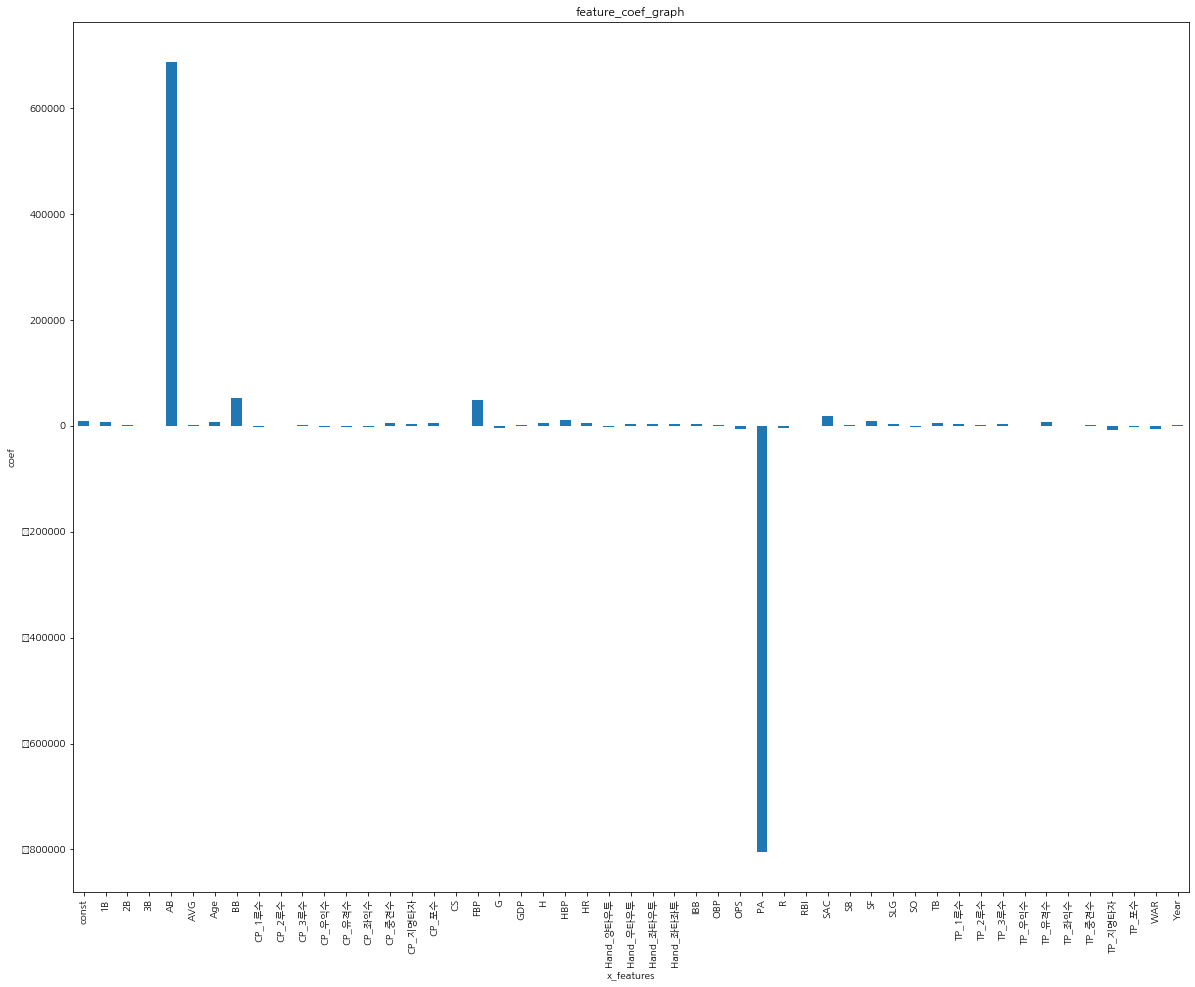

In [24]:
# 그래프 사이즈 조절
plt.rcParams['figure.figsize'] = [20, 16]

# 회귀 계수를 리스트로 반환
coefs = model.params.tolist()
coefs_series = pd.Series(coefs)

# 변수명을 리스트로 반환
x_labels = model.params.index.tolist()

# 회귀 계수를 출력
ax = coefs_series.plot(kind='bar')
ax.set_title('feature_coef_graph')
ax.set_xlabel('x_features')
ax.set_ylabel('coef')
ax.set_xticklabels(x_labels)

-----

### 예측 모델 평가

<b>R2 score</b>

In [25]:
# 학습 데이터와 테스트 데이터로 분리
X = batter_df[batter_df.columns.difference(['Salary'])]
y = batter_df['Salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

# 특성 각각에 대한 scaling을 수행
scale_columns = ['Age', 'G', 'PA', 'AB', 'R', 'H', '1B', '2B', '3B', 'HR', 'TB', 'RBI',
       'SB', 'CS', 'BB', 'HBP', 'FBP', 'IBB', 'SO', 'GDP', 'SAC', 'SF', 'Year', 'WAR', 
       'AVG', 'OBP', 'SLG', 'OPS']  # 범주형 데이터 제외

# 훈련 데이터와 테스트 데이터에 각각 적용
X_train = standard_scaling(X_train, scale_columns)
X_test = standard_scaling(X_test, scale_columns)

In [26]:
# 회귀 분석 모델을 학습
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

In [27]:
# 회귀 분석 모델 평가
print(model.score(X_train, y_train))  # train R2 score를 출력합니다.
print(model.score(X_test, y_test))  # test R2 score를 출력합니다.

0.5334261005855794
0.47674917632523395


<b>RMSE score</b>

In [28]:
# 회귀 분석 모델을 평가합니다.
y_predictions = lr.predict(X_train)
print(sqrt(mean_squared_error(y_train, y_predictions))) # train RMSE score를 출력합니다.
y_predictions = lr.predict(X_test)
print(sqrt(mean_squared_error(y_test, y_predictions))) # test RMSE score를 출력합니다.

14768.124075366939
18413.02982667757


-----

### 특성들의 상관관계 분석

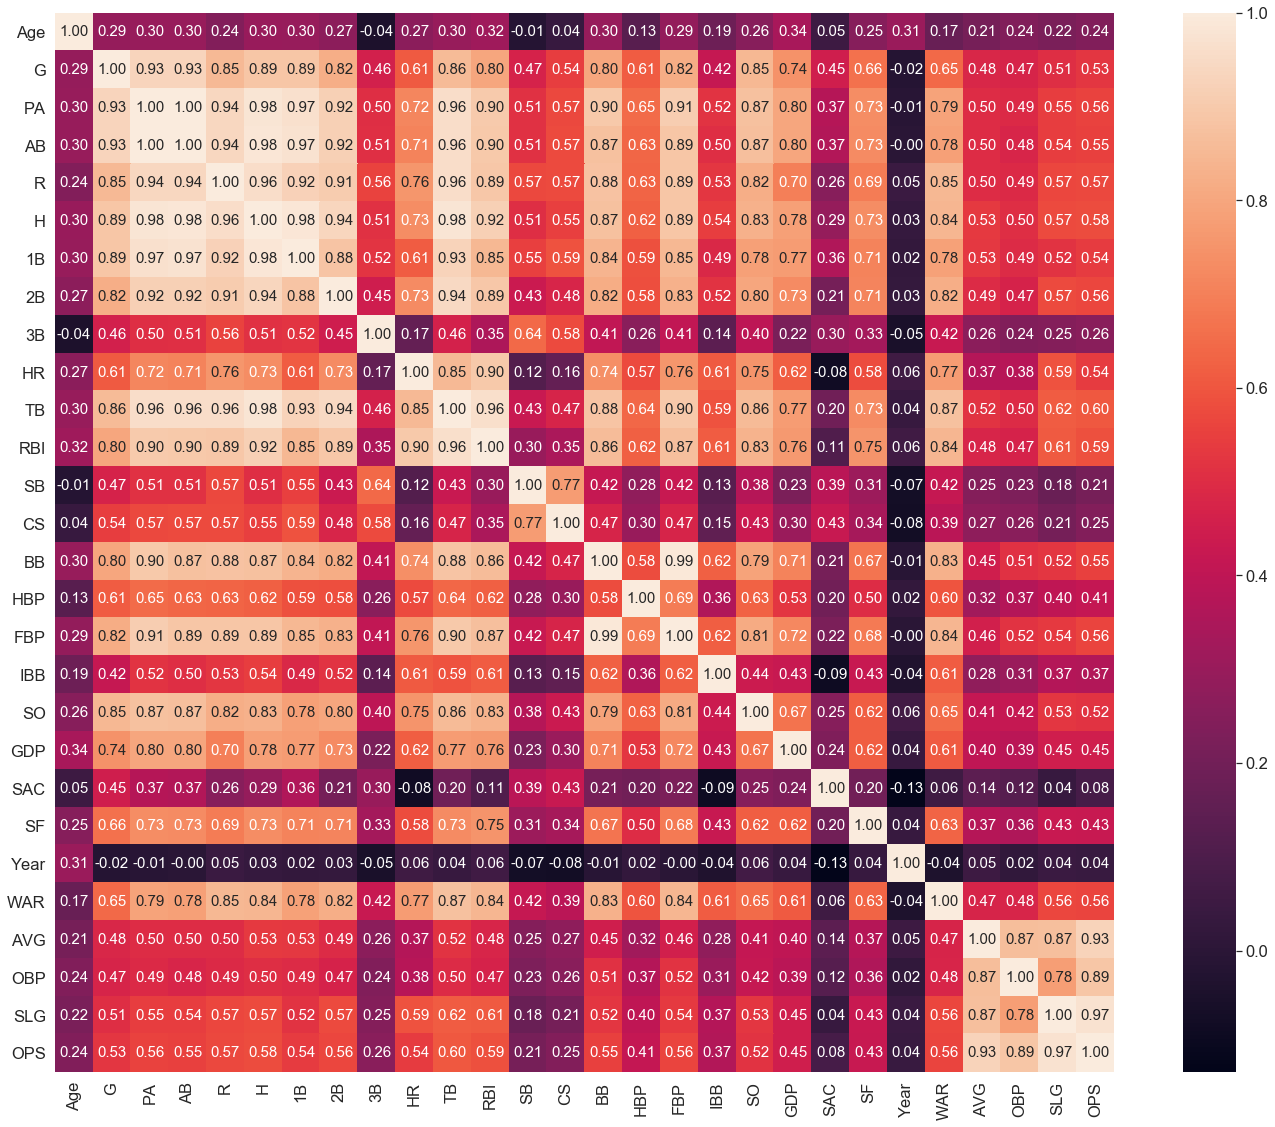

In [29]:
import seaborn as sns

# 피처간의 상관계수 행렬을 계산합니다.
corr = batter_df[scale_columns].corr(method='pearson')
show_cols = ['Age', 'G', 'PA', 'AB', 'R', 'H', '1B', '2B', '3B', 'HR', 'TB', 'RBI',
       'SB', 'CS', 'BB', 'HBP', 'FBP', 'IBB', 'SO', 'GDP', 'SAC', 'SF', 'Year', 'WAR', 
       'AVG', 'OBP', 'SLG', 'OPS']

# corr 행렬 히트맵을 시각화합니다.
plt.rc('font', family='NanumGothic')
sns.set(font_scale=1.5)
hm = sns.heatmap(corr.values,
            cbar=True,
            annot=True, 
            square=True,
            fmt='.2f',
            annot_kws={'size': 15},
            yticklabels=show_cols,
            xticklabels=show_cols)

plt.tight_layout()
plt.show()

-----

### 회귀분석 예측 성능을 높이기 위한 방법: 다중공선성 확인

In [30]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [31]:
# 각 특성의 VIF 계수 출력
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

,VIF Factor,features
0,inf,1B
1,inf,2B
2,inf,3B
3,1469905.0,AB
4,12.0,AVG
5,1.6,Age
6,inf,BB
7,inf,CP_1루수
8,inf,CP_2루수
9,inf,CP_3루수


-----

# 4. 적절한 특성으로 다시 학습하기

## 수행한 과정 기록

### 1회차. VIF가 발산하는 특성을 제거 ('1B', '2B', '3B', 'CP', 'TP', 'Hand', 'H', 'HR')

    공통된 속성을 가진 TB(총 루타 수)만 사용
    
    결과(R2 score): 0.5002329014970613 0.43372310096907973
    
### 2회차. VIF가 발산하는 특성을 제거 - HBP(몸에 맞는 공), FBP(BB + FBP)

    VIF가 발산하는 'BB', 'HBP', 'FBP' 중 타자의 실력과 가장 상관도가 높은 'BB'만 사용
    
    결과(R2 Score): 0.5030571501925983 0.4440144782098854

### 3회차. 'PA' 제거: VIF가 높은 PA(타석)와 AB(타수) 중 AB만 사용

    결과(R2 score): 0.49705866774655993 0.4316355401593175
    
### 4회차. VIF가 가장 높은 'OPS(OBP + SLG)' 제거
    
    결과(R2 score): 0.4969017667232713 0.43286472029478706
    
### 5회차. VIF가 가장 높은  'TB(총 루타 수)' 제거

    결과(R2 score): 0.49367992672011296 0.4247031748372617
    
### 6회차. VIF가 가장 높은  'AB(타수)' 제거
    
    결과(R2 score): 0.4935332705196529 0.4254318104657592
    
### 7회차. VIF가 가장 높은  'AVG(타율)' 제거

    결과(R2 score): 0.4935065237413694 0.4251369171617123
    
---
    
여기까지 했을 때. 다중공선성이 Year(시즌), Age(나이)에서 가장 높게 나타났다. (뭔가 잘못되었다)

모델의 정확도도 매우 낮게 나왔기 때문에. 처음의 가설이 완전히 틀렸다는 것이 증명된 상황

문제의 원인으로 예상되는 점은 '한 선수의 여러 시즌 별 기록이 같은 데이터 셋에 들어가있다'는 것.

결론적으로 <b>사용할 데이터 셋을 크게 조정할 필요가 있어 보임.</b>

In [32]:
# 특성 재선정
batter_df = batter.drop(['Batter_Name', 'Year_Born', 'P_Year', 'YAB', 'YOPS', '1B', '2B', '3B', 'CP', 'TP', 'Hand', 
                         'H', 'HR', 'HBP', 'FBP', 'PA', 'OPS', 'TB', 'AB', 'AVG'], axis=1)

# 손실 데이터 처리
batter_df = batter_df.fillna(0)

# 범주형 데이터(Hand, CP, TP)를 one-hot encoding으로 변환
batter_df = pd.get_dummies(batter_df)

X = batter_df[batter_df.columns.difference(['Salary'])]
y = batter_df['Salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

# 특성 각각에 대한 scaling을 수행
print(X.columns)
scale_columns = ['Age', 'BB', 'CS', 'G', 'GDP', 'IBB', 'OBP',
       'R', 'RBI', 'SAC', 'SB', 'SF', 'SLG', 'SO', 'WAR', 'Year']  # X.columns

# 훈련 데이터와 테스트 데이터에 각각 적용
X_train = standard_scaling(X_train, scale_columns)
X_test = standard_scaling(X_test, scale_columns)

Index(['Age', 'BB', 'CS', 'G', 'GDP', 'IBB', 'OBP', 'R', 'RBI', 'SAC', 'SB',
       'SF', 'SLG', 'SO', 'WAR', 'Year'],
      dtype='object')


In [33]:
# 모델을 학습합니다.
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

In [34]:
# 결과를 출력합니다.
print(model.score(X_train, y_train)) # train R2 score를 출력합니다.
print(model.score(X_test, y_test)) # test R2 score를 출력합니다.

0.4935065237413694
0.4251369171617123


In [35]:
# 회귀 분석 모델을 평가합니다.
y_predictions = lr.predict(X_train)
print(sqrt(mean_squared_error(y_train, y_predictions))) # train RMSE score를 출력합니다.
y_predictions = lr.predict(X_test)
print(sqrt(mean_squared_error(y_test, y_predictions))) # test RMSE score를 출력합니다.

15386.932204496568
19299.786561040375


In [36]:
# 피처마다의 VIF 계수를 출력합니다.
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

,VIF Factor,features
0,45.1,Age
1,15.9,BB
2,4.8,CS
3,32.7,G
4,6.4,GDP
5,2.4,IBB
6,30.0,OBP
7,32.3,R
8,31.0,RBI
9,2.8,SAC


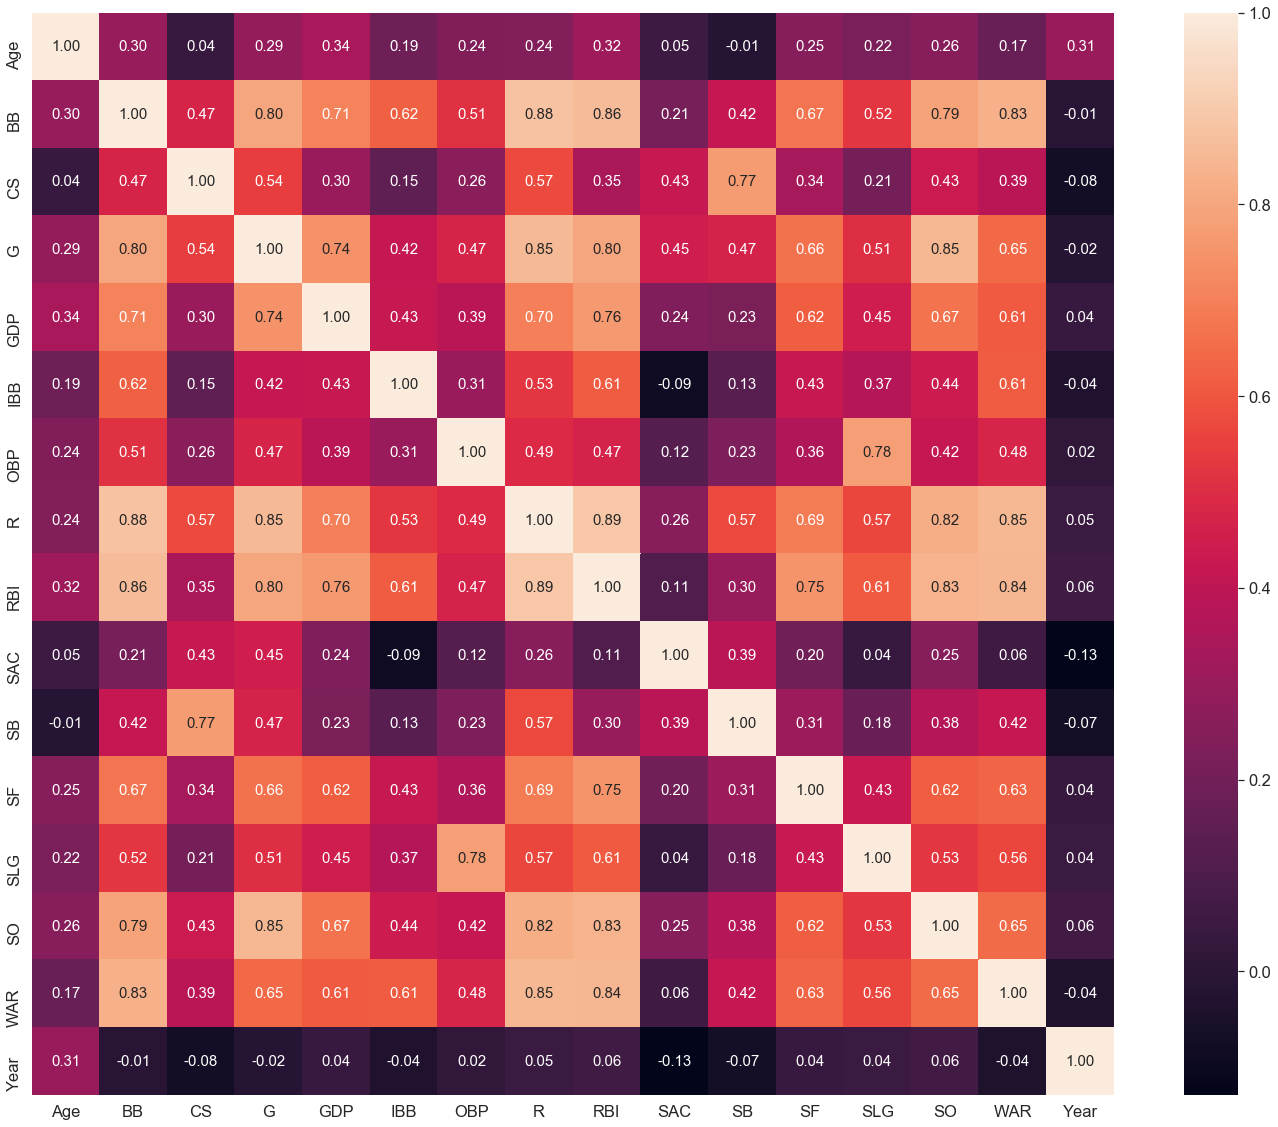

In [38]:
# 피처간의 상관계수 행렬을 계산합니다.
corr = batter_df[scale_columns].corr(method='pearson')
show_cols = ['Age', 'BB', 'CS', 'G', 'GDP', 'IBB', 'OBP',
       'R', 'RBI', 'SAC', 'SB', 'SF', 'SLG', 'SO', 'WAR', 'Year']

# corr 행렬 히트맵을 시각화합니다.
plt.rc('font', family='NanumGothic')
sns.set(font_scale=1.5)
hm = sns.heatmap(corr.values,
            cbar=True,
            annot=True, 
            square=True,
            fmt='.2f',
            annot_kws={'size': 15},
            yticklabels=show_cols,
            xticklabels=show_cols)

plt.tight_layout()
plt.show()